C:\Users\bolto\AppData\Local\Temp\ipykernel_109760\2988305811.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


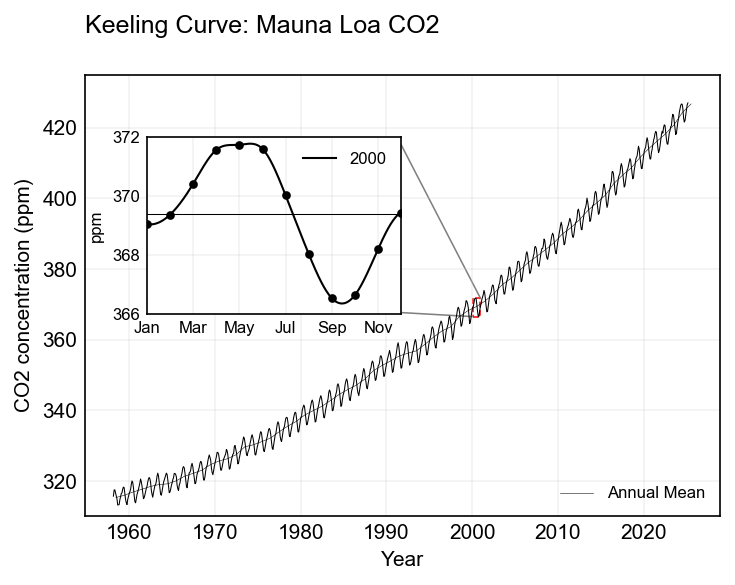

Figure saved as C:\Users\bolto\Documents\EarthHistoryStratigraphy\ClassBook\graphics\keeling_curve.pdf


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch, Rectangle
from scipy.interpolate import make_interp_spline
import calendar
import matplotlib.dates as mdates

# ------------------------------------------------------------------
# 1.  Set rcParams (styling)
# ------------------------------------------------------------------
plt.rcParams['axes.titlelocation'] = 'left'
plt.rcParams['axes.titlepad']      = 10
plt.rcParams['legend.frameon']     = False
plt.rcParams['xtick.direction']    = 'in'
plt.rcParams['ytick.direction']    = 'in'
plt.rcParams['axes.grid']          = True
plt.rcParams['grid.color']         = '0.8'
plt.rcParams['grid.linestyle']     = '-'
plt.rcParams['grid.alpha']         = 0.25
plt.rcParams['svg.fonttype']       = 'none'
plt.rcParams['pdf.fonttype']       = 42
plt.rcParams['font.family']        = 'Arial'
plt.rcParams['text.usetex']        = False

# ------------------------------------------------------------------
# 2.  Define paths
# ------------------------------------------------------------------
DATA_FILE    = Path("../data/monthly_in_situ_co2_mlo.csv")
GRAPHICS_DIR = Path("../graphics")
GRAPHICS_DIR.mkdir(parents=True, exist_ok=True)
FIG_PATH     = GRAPHICS_DIR / "keeling_curve.pdf"  # Save as vector PDF

# ------------------------------------------------------------------
# 3.  Load & prepare the data
# ------------------------------------------------------------------
COLS = ["Year", "Month", "ExcelDate", "DecimalDate",
        "CO2", "CO2_adj", "Fit", "Fit_adj",
        "CO2_filled", "CO2_filled_adj", "Sta"]

df = (
    pd.read_csv(DATA_FILE, skiprows=range(0, 64), header=None, names=COLS)
      .loc[lambda d: d.CO2 != -99.99]
      .assign(Date=lambda d: pd.to_datetime(dict(year=d.Year, month=d.Month, day=15)))
)

# ------------------------------------------------------------------
# 4.  Create the main minimalist Tufte-style plot
# ------------------------------------------------------------------
fig = plt.figure(figsize=(5, 4), dpi=150)
ax_main = fig.add_subplot(1, 1, 1)

# Plot the full monthly record (black line)
ax_main.plot(df.Date, df.CO2, linewidth=0.5, color='k')
ax_main.set_title("Keeling Curve: Mauna Loa CO2", pad=20)
ax_main.set_ylabel("CO2 concentration (ppm)")
ax_main.set_xlabel("Year")
ax_main.tick_params(axis="both", which="both", length=0)

# Compute annual means for the entire dataset and plot as a red line
annual_mean_df = df.groupby("Year")["CO2"].mean().reset_index()
annual_mean_df["Date"] = pd.to_datetime(annual_mean_df["Year"].astype(str) + "-07-01")
ax_main.plot(annual_mean_df["Date"], annual_mean_df["CO2"],
             color='black', linestyle='-', linewidth=0.25, label="Annual Mean")

ax_main.legend(loc="lower right", fontsize=8, frameon=False)

ax_main.set_ylim(310, 435)

# ------------------------------------------------------------------
# 5.  Add inset: Seasonal trends for 2000 (smoothed)
# ------------------------------------------------------------------
# Focus on the year of interest now: 2000
year = 2000
inset_df = df[df.Year == year].copy()
yearly_data = inset_df.sort_values("Month")

# Determine the seasonal y-range (CO₂ values) for 2000
y0 = yearly_data.CO2.min()
y1 = yearly_data.CO2.max()

# Prepare data for smoothing (x: months 1–12; y: CO₂ values)
x = yearly_data.Month.values  
y = yearly_data.CO2.values

# Generate a smooth curve using cubic spline interpolation
x_smooth = np.linspace(x.min(), x.max(), 300)
spline = make_interp_spline(x, y, k=3)
y_smooth = spline(x_smooth)

ax_inset = inset_axes(ax_main, width="40%", height="40%", loc="upper left", borderpad=3)
ax_inset.plot(x_smooth, y_smooth, color='k', linewidth=1)
ax_inset.scatter(x, y, color='k', s=10, zorder=5)

# Add a horizontal black dashed line for the annual mean in 2000
annual_2000 = yearly_data.CO2.mean()
ax_inset.axhline(annual_2000, color='black', linestyle='-', linewidth=0.5, label="Annual Mean")

# Set inset limits explicitly so its frame represents the seasonal window exactly
ax_inset.set_xlim(1, 12)
ax_inset.set_ylim(y0, y1)

# Format the inset x-axis with abbreviated month labels for every other month
xticks = list(range(1, 13, 2))
xtick_labels = [calendar.month_abbr[i] for i in xticks]
ax_inset.set_xticks(xticks)
ax_inset.set_xticklabels(xtick_labels, fontsize=8)
ax_inset.tick_params(axis="both", which="both", length=0, labelsize=8)
ax_inset.set_ylabel("ppm", fontsize=8)
ax_inset.legend([str(year)], frameon=False, fontsize=8, loc="upper right")
ax_inset.set_ylim(366, 372)

# ------------------------------------------------------------------
# 6.  Draw connecting lines for the frame region
# ------------------------------------------------------------------
# Define the main plot seasonal region for 2000:
# x-range: January 15 to December 15, 2000 (converted to float)
x0_main = mdates.date2num(pd.Timestamp("2000-01-15"))
x1_main = mdates.date2num(pd.Timestamp("2000-12-15"))
# y-range: use the seasonal minimum and maximum values from 2000
y0_main = y0
y1_main = y1

# Draw a rectangle on the main plot to highlight the seasonal window
rect = Rectangle((x0_main, y0_main), x1_main - x0_main, y1_main - y0_main,
                 fill=False, edgecolor='red', linestyle='--', linewidth=0.75)
ax_main.add_patch(rect)

# Draw connection lines from the inset frame to the main rectangle.
# Here, we connect the lower left and upper right corners.
cp_ll = ConnectionPatch(xyA=(1, y0), coordsA=ax_inset.transData,
                        xyB=(x0_main, y0_main), coordsB=ax_main.transData,
                        arrowstyle="-", color="gray", linewidth=0.75)
ax_main.add_artist(cp_ll)

cp_ur = ConnectionPatch(xyA=(12, y1), coordsA=ax_inset.transData,
                        xyB=(x1_main, y1_main), coordsB=ax_main.transData,
                        arrowstyle="-", color="gray", linewidth=0.75)
ax_main.add_artist(cp_ur)

# Optionally, connect the other two corners for a complete frame connection
cp_ul = ConnectionPatch(xyA=(1, y1), coordsA=ax_inset.transData,
                        xyB=(x0_main, y1_main), coordsB=ax_main.transData,
                        arrowstyle="-", color="gray", linewidth=0.75)
#ax_main.add_artist(cp_ul)

cp_lr = ConnectionPatch(xyA=(12, y0), coordsA=ax_inset.transData,
                        xyB=(x1_main, y0_main), coordsB=ax_main.transData,
                        arrowstyle="-", color="gray", linewidth=0.75)
#ax_main.add_artist(cp_lr)

# ------------------------------------------------------------------
# 7.  Save and show the figure
# ------------------------------------------------------------------
plt.tight_layout()
plt.savefig(FIG_PATH, bbox_inches="tight")
plt.show()

print(f"Figure saved as {FIG_PATH.resolve()}")


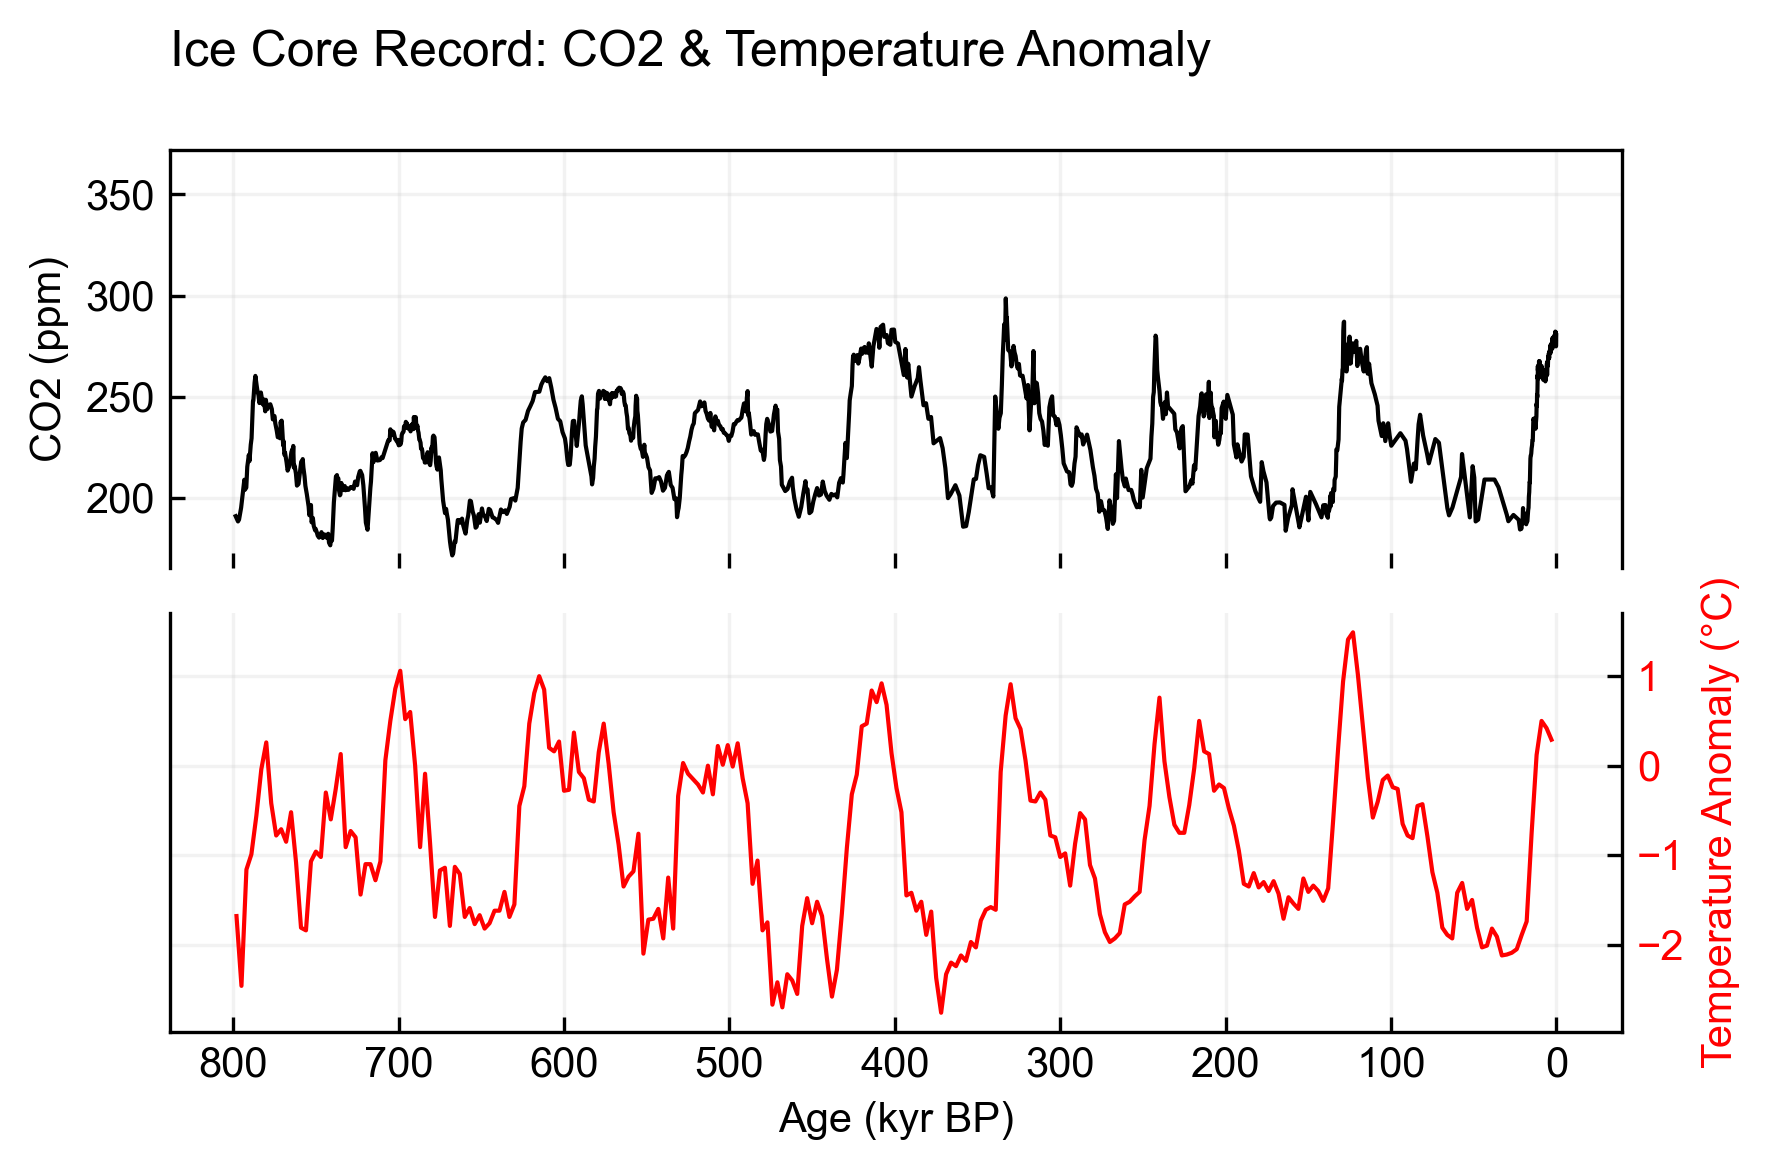

Figure saved as C:\Users\bolto\Documents\EarthHistoryStratigraphy\ClassBook\graphics\ice_core_dual_axis_equal.pdf


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter  # Import the formatter

# ------------------------------------------------------------------
# 1. Set rcParams for a minimalist Tufte‑style look
# ------------------------------------------------------------------
plt.rcParams['axes.titlelocation'] = 'left'
plt.rcParams['axes.titlepad']      = 10
plt.rcParams['legend.frameon']     = False
plt.rcParams['xtick.direction']    = 'in'
plt.rcParams['ytick.direction']    = 'in'
plt.rcParams['axes.grid']          = True
plt.rcParams['grid.color']         = '0.8'
plt.rcParams['grid.linestyle']     = '-'
plt.rcParams['grid.alpha']         = 0.25
plt.rcParams['svg.fonttype']       = 'none'
plt.rcParams['pdf.fonttype']       = 42
plt.rcParams['font.family']        = 'Arial'
plt.rcParams['text.usetex']        = False

# ------------------------------------------------------------------
# 2. Define file path and output
# ------------------------------------------------------------------
DATA_FILE = Path("../data/ice_core_Luthi2008.xls")
GRAPHICS_DIR = Path("../graphics")
GRAPHICS_DIR.mkdir(parents=True, exist_ok=True)
FIG_PATH = GRAPHICS_DIR / "ice_core_dual_axis_equal.pdf"  # Save as vector PDF

# ------------------------------------------------------------------
# 3. Load the data from the Excel file
# ------------------------------------------------------------------
# Read the CO₂ data from the "3.  Composite CO2" sheet.
co2_df = pd.read_excel(DATA_FILE, sheet_name="3.  Composite CO2")
# Read the temperature anomaly data from the "temp_data" sheet.
temp_df = pd.read_excel(DATA_FILE, sheet_name="temp_data")

# Sort data by age for proper plotting
co2_age = "EDC3_gas_a (yr)"
temp_age = "Age (yr BP)"
co2_df = co2_df.sort_values(co2_age)
temp_df = temp_df.sort_values(temp_age)

# ------------------------------------------------------------------
# 4. Create a two-panel (vertical) plot with equal panel sizes
# ------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), dpi=300, sharex=True,
                               gridspec_kw={'height_ratios': [1, 1]})

# Top panel: CO₂ record
ax1.plot(co2_df[co2_age], co2_df["CO2 (ppmv)"], color='black', linewidth=1, label="Ice Core CO2")
ax1.set_ylabel("CO2 (ppm)", color='black')
ax1.tick_params(axis="y", labelcolor='black')
ax1.set_title("Ice Core Record: CO2 & Temperature Anomaly", loc="left", pad=20)
# Set y-axis maximum to 372 to match the Keeling curve graph
ax1.set_ylim(top=372)
# Remove the bottom spine of the top graph
ax1.spines['bottom'].set_visible(False)

# Bottom panel: Temperature anomaly
ax2.plot(temp_df[temp_age], temp_df["Temperature Anomaly (°C) "], color='red', linewidth=1, label="Temperature Anomaly")
ax2.set_xlabel("Age (kyr BP)")
ax2.set_ylabel("Temperature Anomaly (°C)", color='red')
# Move the ticks and label to the right side for the bottom panel.
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.tick_params(axis="y", labelcolor='red')
# Remove the top spine of the bottom graph
ax2.spines['top'].set_visible(False)

# ------------------------------------------------------------------
# 5. Format the x-axis to display age in kyr without decimals and reverse x-axis
# ------------------------------------------------------------------
formatter = FuncFormatter(lambda x, pos: f"{x/1000:.0f}")
ax1.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_formatter(formatter)
# Reverse the x-axis direction on both panels
ax1.invert_xaxis()

plt.tight_layout()
plt.savefig(FIG_PATH, bbox_inches="tight")
plt.show()

print(f"Figure saved as {FIG_PATH.resolve()}")
